In [77]:
import pandas as pd
import numpy as np
from io import StringIO
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import seaborn as sns
sns.set(font_scale=2)
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import scipy.optimize as opt

In [97]:
# Correct Code
import time
import scipy.linalg as spla

# Introduction

A tumor is a mass of abnormal tissue. Malignant and benign tumors have different cell growth characteristics.

For this activity, you will use python libraries such as `seaborn` and `scikit-learn` to:

* explore the data using vizualization tools
* run PCA to reduce the dimension of the dataset
* split your data into training and test sets
* create a model to predict wheter a tumor is malignant (cancerous / deadly) or benign (non-cancerous / safe) based on the tumor properties. 


### Load the dataset

In [3]:
params = ["radius", "texture", "perimeter", "area",
          "smoothness", "compactness", "concavity",
          "concave points", "symmetry", "fractal dimension"];
stats = ["(mean)", "(stderr)", "(worst)"]
labels = ["patient ID", "Malignant/Benign"]

for p in params:
    for s in stats:
        labels.append(p + " " + s)

tumor_data = pd.io.parsers.read_csv("breast-cancer-dataset.dat",header=None,names=labels)

feature_labels = labels[2:]

How many features in this dataset? How many patients?

In [4]:
#clear
M = len(tumor_data)
N = len(feature_labels)
print("# of patients = ", M)
print("# of features = ", N)

# of patients =  560
# of features =  30


In [98]:
subset_headers = ['area (mean)','concavity (mean)','fractal dimension (mean)','compactness (mean)']
b_header = np.random.choice(["radius (mean)",'perimeter (mean)'])
A = np.float64(tumor_data[subset_headers].values)
b = np.float64(tumor_data[b_header].values)

In [108]:
def func(x,A,b):
    r = A@x-b
    return 0.5*np.inner(r,r)

def dfunc(x,A,b):
    return A.T@(A@x-b)

def d2func(x,A,b):
    return A.T@A

def obj(alpha,x,grad,A,b):
    return func(x+alpha*grad,A,b)

In [117]:
def solve_lstsq(A, b, solve_type):
    x0 = np.random.rand(A.shape[1])
    if solve_type == "svd":
        U, sigma, VT = la.svd(A, full_matrices=False)
        return VT.T @ ((U.T @ b) / sigma)
    elif solve_type == "newton":
        x_n = x0.copy()
        Hinv = la.pinv(A.T @ A)
        x_n = x_n - Hinv @ dfunc(x_n,A,b)
        return x_n
    elif solve_type == "gd_fixed":
        x_fix = x0.copy()
        er = 1
        while er > 1e-5:
            x_new = x_fix - alpha * dfunc(x_fix,A,b)
            er = la.norm(x_new-x_fix)
            x_fix = x_new
        return x_fix
    elif solve_type == "gd_variable":
        x_var = x0.copy()
        er = 1
        while er > 1e-5:
            grad = -dfunc(x_var,A,b)
            alpha_star = opt.minimize_scalar(obj, args=(x_var,grad,A,b)).x
            x_new = x_var + alpha_star * grad
            er = la.norm(x_new-x_var)
            x_var = x_new
        return x_var


In [118]:
x = solve_lstsq(A, b, "svd")
print(x)
print(solve_lstsq(A, b, "newton"))
print(solve_lstsq(A, b, "gd_fixed"))
print(solve_lstsq(A, b, "gd_variable"))

[-0.93913797  0.68443649  0.83496147  1.50310229]
[-0.93913797  0.68443649  0.83496147  1.50310229]
[-0.93839068  0.68209444  0.8348685   1.50357907]
[-0.9388936   0.68367109  0.83493139  1.50325818]


In [102]:
x0 = np.random.rand(A.shape[1])

ftrue = func(x0,A,b)
dx = 0.0001
gradFD = np.zeros(x0.shape)
for i in range(len(x0)):
    xval = np.copy(x0)
    xval[i] += dx
    gradFD[i] = (func(xval,A,b)-ftrue)/dx
    
print(gradFD)
print(dfunc(x0,A,b))

[-0.93964363 -0.31934407 -3.2789598  -0.65848936]
[-0.93975552 -0.31935784 -3.27944134 -0.65851636]


In [103]:
indices = np.arange(len(b))
np.random.shuffle(indices)
def get_data(n):
    return A[indices[:n], :], b[indices[:n]]

[50, 100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400, 204800, 409600]
(50, 4)
(100, 4)
(200, 4)
(400, 4)
(560, 4)
(560, 4)
(560, 4)
(560, 4)
(560, 4)
(560, 4)
(560, 4)
(560, 4)
(560, 4)
(560, 4)


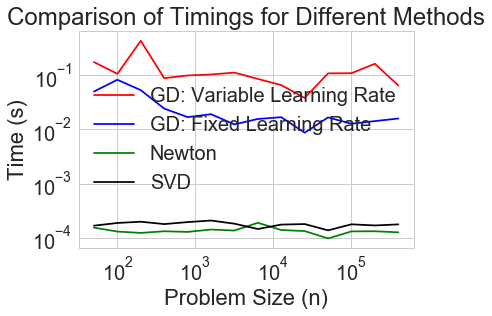

In [120]:
methods = ["svd", "newton", "gd_fixed", "gd_variable"]
times = [[], [], [], []]
ns = [50*2**i for i in range(14)]
print(ns)
for n in ns:
    An, bn = get_data(n)
    print(An.shape)
    for i, stype in enumerate(methods):
        s = time.time()
        solve_lstsq(An, bn, solve_type=stype)
        diff = time.time() - s
        times[i].append(diff)


plt.plot(ns, times[3], 'r', label='GD: Variable Learning Rate')
plt.plot(ns, times[2], 'b', label='GD: Fixed Learning Rate ')
plt.plot(ns, times[1], 'g', label='Newton')
plt.plot(ns, times[0], 'k', label='SVD')

plt.yscale('log')
plt.xscale('log')
plt.title("Comparison of Timings for Different Methods")
plt.xlabel("Problem Size (n)")
plt.ylabel("Time (s)")
plt.legend(loc=0)
plt.show()